In [1]:
import numpy as np
import matplotlib.pyplot as plt
from myVNS import MyVNS
from myProblem import MyProblem

class Struct:
    pass

# Loop principal começa aqui

Rodando execução 1...


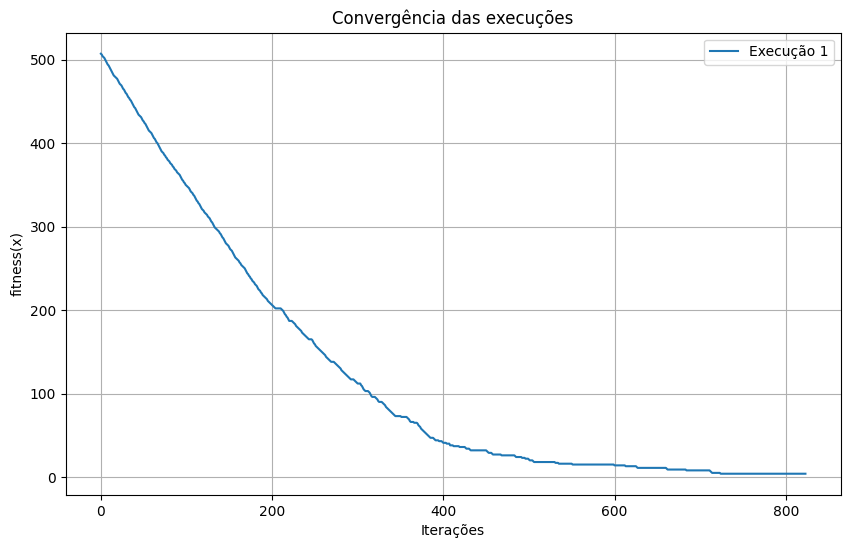


--- RESULTADOS FINAIS ---
Melhores fitness encontrados: [np.int64(4)]
Média: 4.0000
Desvio padrão: 0.0000


In [2]:
import matplotlib.pyplot as plt
import numpy as np

num_execucoes = 1
max_num_sol_avaliadas = 1000
kmax = 3

convergencias = []
melhores_fitness = []

def is_convergence_good(history, tol_size, tol):
    if len(history) < 10:
        return False  # or handle this case as needed
       
    last_tol = history[-tol_size:]  # Get the last tol_size elements
    std = np.std(last_tol)

    return std < tol


for execucao in range(num_execucoes):
    print(f'Rodando execução {execucao + 1}...')

    # Cria instâncias dos objetos
    myProblem = MyProblem()
    myVNS = MyVNS()

    # Gera os dados do problema
    probdata = myProblem.probdef()

    # Gera uma solução inicial
    sol_inicial = myProblem.sol_inicial(probdata, apply_constructive_heuristic=False)

    # Escolhe a função objetivo
    func_obj = myProblem.fobj_epsilon_restrito  # Troque para fobj1 se quiser

    fitness_sol_inicial = func_obj(sol_inicial, probdata)
    num_sol_avaliadas = 1

    historico = Struct()

    historico.sol = []
    historico.fit = []
    historico.sol.append(sol_inicial)
    historico.fit.append(myProblem.fobj1(sol_inicial, probdata))

    sol_atual = sol_inicial
    fitness_atual = fitness_sol_inicial

    # loop principal (BVNS)
    tol = 10**(-5) # desvio padrao
    tol_iteractions = 100

    # se nas ultimas tol_iteractions a diferenca entre os fitness for menor que tol, para

    while num_sol_avaliadas < max_num_sol_avaliadas:
        k = 1
        previous_fitness = 0
        stop_flag = False
        while k <= kmax:
            num_sol_avaliadas += 1

            # Gera uma solução candidata na k-ésima vizinhança de x 
            sol_candidata = myVNS.shake(sol_atual, k, probdata)

            # faz uma busca local a partir da solução candidata do shake
            # sol_local = myVNS.firstImprovement(sol_candidata, probdata, func_obj, k)
            sol_local = myVNS.bestImprovement(sol_candidata, probdata, func_obj, k)

            # Atualiza solução corrente e estrutura de vizinhança (se necessário)
            x, k = myVNS.neighborhoodChange(sol_atual, sol_local, k, func_obj, probdata)

            sol_atual = x
            fitness_atual = func_obj(sol_atual, probdata)

            # dados para plot
            historico.sol.append(sol_atual)
            historico.fit.append(myProblem.fobj1(sol_atual, probdata))

            # checa a convergencia
            if is_convergence_good(historico.fit, tol_iteractions, tol):
                stop_flag = True
                break
            else:
                previous_fitness = myProblem.fobj1(sol_atual, probdata)

        if stop_flag: 
            break

    convergencias.append(historico.fit)
    melhores_fitness.append(myProblem.fobj1(sol_atual, probdata))

# --- PLOTAGEM DAS CURVAS DE CONVERGÊNCIA ---
plt.figure(figsize=(10,6))
for i in range(num_execucoes):
    plt.plot(convergencias[i], label=f'Execução {i+1}')
plt.title('Convergência das execuções')
plt.xlabel('Iterações')
plt.ylabel('fitness(x)')
plt.legend()
plt.grid(True)
plt.show()

# --- ESTATÍSTICAS FINAIS ---
media_fitness = np.mean(melhores_fitness)
desvio_fitness = np.std(melhores_fitness)

print(f'\n--- RESULTADOS FINAIS ---')
print(f'Melhores fitness encontrados: {melhores_fitness}')
print(f'Média: {media_fitness:.4f}')
print(f'Desvio padrão: {desvio_fitness:.4f}')
